<a href="https://colab.research.google.com/github/nikashahabi/Cryptic-Unstable-Transcripts-Identification-with-Deep-Learning/blob/main/Part3_TrainingClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.utils import resample
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from keras import backend as K
from sklearn.utils import class_weight

In [ ]:

noncoding_sq_df = pd.read_pickle("/content/drive/MyDrive/Bioinformatics/noncoding_sq_df.pkl")
cuts_sq_df = pd.read_pickle("/content/drive/MyDrive/Bioinformatics/cuts_sq_df.pkl")
all_sq_df = pd.concat([noncoding_sq_df, cuts_sq_df])
shuffled_df = all_sq_df.sample(frac = 1)

In [ ]:
shuffled_df.reset_index(drop=True,inplace=True)

In [ ]:
shuffled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1128 non-null   int64  
 1   sequence    1128 non-null   object 
 2   label       219 non-null    float64
 3   vectors     776 non-null    object 
 4   labels      909 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 44.2+ KB


In [ ]:
((shuffled_df['label'] == 0) | (shuffled_df['labels'] == 1)).all()

True

so in every row, either `label` is `0`, or `labels` is `1`.

removing `labels` column

In [ ]:
shuffled_df.drop(columns=['labels'],inplace=True)

replacing `label` column `None`s with `1`

In [ ]:
shuffled_df['label'] = shuffled_df['label'].fillna(1).astype(int)

removing rows with `None` value vector.

In [ ]:
df = shuffled_df.drop(labels=shuffled_df[shuffled_df['vectors'].isna()].index)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 776 entries, 1 to 1125
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  776 non-null    int64 
 1   sequence    776 non-null    object
 2   label       776 non-null    int64 
 3   vectors     776 non-null    object
dtypes: int64(2), object(2)
memory usage: 30.3+ KB


In [ ]:
# df['vectors'][0].shape

KeyError: ignored

In [ ]:
df['vectors'].apply(lambda x:x.shape == (768,1)).all()

False

so every vector in `vectors` column has $(768,1)$ shape,
converting to $(768,)$ shape.

In [ ]:
df['vectors'] = df['vectors'].apply(np.squeeze)

now every vector has $(768,)$ shape

In [ ]:
df['vectors'].apply(lambda x:x.shape == (768,)).all()

True

,Unnamed: 0,sequence,label,vectors
1,2,GGTTGTTTGGCCGAGCGGTCTAAGGCGCCTGATTCAAGAAATATCT...,0,"[0.33361390233039856, -0.23799723386764526, 1...."
2,700,GTCATAGCATGCTGTGTTGTAAATGTGATCTGTCTGAGACGTGTCA...,1,"[0.0014860546216368675, 0.1138811931014061, 0...."
5,272,CATCCTACGTAAAACCCGAATAGGTTATCTCTTAAACCTTGTTTTC...,1,"[0.1040114015340805, -0.2792070508003235, 0.89..."
7,3,GGGCGTGTGGTCTAGTGGTATGATTCTCGCTTTGGGCGACTTCCTG...,0,"[0.0976698249578476, -0.07576256990432739, 1.2..."
8,131,TTCCTCGTGGCCCAATGGTCACGGCGTCTGGCTACGAACCAGGAGA...,0,"[0.18842077255249023, 0.11721798032522202, 1.1..."
...,...,...,...,...
1120,111,TCATAATGATGATTTCACTTATACCTATATGTTTTTTCTGGCATCT...,0,"[-0.27484214305877686, 0.232264906167984, -0.2..."
1122,418,GTGAAACTGTACAAGGTGCCTAAACAGAGATACGAACGCATACGCT...,1,"[0.07412852346897125, -0.08573958277702332, 0...."
1123,662,AATAATTGAGTATATGTTCGTATAGCATGGCGTGTCTTATTGGTAG...,1,"[-0.3331521451473236, 0.09635738283395767, 0.2..."
1124,426,TTTTTTGACTTAAGGCATTAAGAGGAGATAAGGCTCCTAATGTCAC...,1,"[0.05117061734199524, -0.36521729826927185, 0...."


In [ ]:
df.drop(["Unnamed: 0"], axis=1)

,sequence,label,vectors
1,GGTTGTTTGGCCGAGCGGTCTAAGGCGCCTGATTCAAGAAATATCT...,0,"[0.33361390233039856, -0.23799723386764526, 1...."
2,GTCATAGCATGCTGTGTTGTAAATGTGATCTGTCTGAGACGTGTCA...,1,"[0.0014860546216368675, 0.1138811931014061, 0...."
5,CATCCTACGTAAAACCCGAATAGGTTATCTCTTAAACCTTGTTTTC...,1,"[0.1040114015340805, -0.2792070508003235, 0.89..."
7,GGGCGTGTGGTCTAGTGGTATGATTCTCGCTTTGGGCGACTTCCTG...,0,"[0.0976698249578476, -0.07576256990432739, 1.2..."
8,TTCCTCGTGGCCCAATGGTCACGGCGTCTGGCTACGAACCAGGAGA...,0,"[0.18842077255249023, 0.11721798032522202, 1.1..."
...,...,...,...
1120,TCATAATGATGATTTCACTTATACCTATATGTTTTTTCTGGCATCT...,0,"[-0.27484214305877686, 0.232264906167984, -0.2..."
1122,GTGAAACTGTACAAGGTGCCTAAACAGAGATACGAACGCATACGCT...,1,"[0.07412852346897125, -0.08573958277702332, 0...."
1123,AATAATTGAGTATATGTTCGTATAGCATGGCGTGTCTTATTGGTAG...,1,"[-0.3331521451473236, 0.09635738283395767, 0.2..."
1124,TTTTTTGACTTAAGGCATTAAGAGGAGATAAGGCTCCTAATGTCAC...,1,"[0.05117061734199524, -0.36521729826927185, 0...."


counting `0` and `1` classes

In [ ]:
df.to_pickle('/content/drive/MyDrive/Bioinformatics/shuffled_sq_with_labels_and_encodings.pkl')

In [ ]:
df['label'].value_counts()

1    589
0    187
Name: label, dtype: int64

### Run from here if it is not your first time here

In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/Bioinformatics/shuffled_sq_with_labels_and_encodings.pkl")

so data is highly unbalanced.

## Oversampling

In [ ]:
# in ghesmat daashtam talash mikardam ke dasti upsample konam. comment kardam va az loss e amade estefade kardam

In [ ]:
# df_majority = df[df.label==1]
# df_minority = df[df.label==0]

# # Upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=len(df_majority),    # to match majority class
#                                  random_state=42) # reproducible results

# # Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [ ]:
# Display new class counts
# df_upsampled.label.value_counts()

In [ ]:
# X = np.stack(df_upsampled['vectors'])
# y = df_upsampled['label']

In [ ]:
X = np.stack(df['vectors'])
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_final, X_validation_final, y_train_final, y_validation_final = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## Cross Validation start

In [ ]:
kf = KFold(n_splits = 5)                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

NameError: ignored

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
def create_new_model():
  return keras.models.Sequential([
        keras.layers.Dense(50,input_dim=768, activation="relu"),
      keras.layers.Dense(25, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

In [ ]:
def plotLearningCurve(history, optimizer):
    'plotting the learning curve'
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title(label="keras_learning_curves_plot_with_" + optimizer + "_optimizer")
    plt.show()
    # plt.close("all")

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
EPOCHS = 50
OPTIMIZER = "adam"
METRICS=["accuracy",f1]
LOSS="binary_crossentropy"
create_new_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                38450     
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 39,751
Trainable params: 39,751
Non-trainable params: 0
_________________________________________________________________


## Cross Validation

In [ ]:

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
fold_var = 1
best_result = -1*np.inf

for train_index, val_index in kf.split(np.zeros(len(y_train)),y_train):
  print(f"fold:{fold_var}")
  training_data = X_train[train_index]
  training_data_y = y_train.iloc[train_index]
  # Calculate the weights for each class so that we can balance the data
  classes=np.unique(training_data_y)
  weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=classes,
                                            y=training_data_y)
  class_weights = {i: weights[i] for i in classes}
  validation_data = X_train[val_index]
  validation_data_y = y_train.iloc[val_index]
  # CREATE NEW MODEL
  model = create_new_model()
  # COMPILE NEW MODEL
  model.compile(loss=LOSS,optimizer=OPTIMIZER,metrics=METRICS)
	# FIT THE MODEL
  history = model.fit(training_data,training_data_y,epochs=EPOCHS,validation_data=(validation_data,validation_data_y),verbose=0, class_weight=class_weights)
	
  results = model.evaluate(validation_data,validation_data_y)
  results = dict(zip(model.metrics_names,results))

  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])

  #saving best model yet
  if results['f1'] > best_result:
    print(f"best performance increased. saving model: {best_result} -> {results['f1']}")
    best_result = results['f1']
    model.save('./best_model.h5')

  tf.keras.backend.clear_session()
	
  fold_var += 1
	

fold:1
4/4 [==============================] - 0s 4ms/step - loss: 0.2335 - accuracy: 0.8871 - f1: 0.9311
best performance increased. saving model: -inf -> 0.9311201572418213
fold:2
4/4 [==============================] - 0s 4ms/step - loss: 0.3966 - accuracy: 0.8790 - f1: 0.9219
fold:3
4/4 [==============================] - 0s 4ms/step - loss: 0.3042 - accuracy: 0.9194 - f1: 0.9501
best performance increased. saving model: 0.9311201572418213 -> 0.9501156806945801
fold:4
4/4 [==============================] - 0s 4ms/step - loss: 0.4564 - accuracy: 0.7823 - f1: 0.8351
fold:5
4/4 [==============================] - 0s 4ms/step - loss: 0.4654 - accuracy: 0.8548 - f1: 0.8950


## Training Final Model

In [ ]:
EPOCHS = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
classes=np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight='balanced',
                                          classes=classes,
                                          y=y_train)
class_weights = {i: weights[i] for i in classes}
# CREATE NEW MODEL
model = create_new_model()
# COMPILE NEW MODEL
model.compile(loss=LOSS,optimizer=OPTIMIZER,metrics=METRICS)
# FIT THE MODEL
history = model.fit(X_train_final,y_train_final,epochs=EPOCHS,validation_data=(X_validation_final,y_validation_final),verbose=1, class_weight=class_weights, callbacks=[callback])
model.save('./final_model.h5')

tf.keras.backend.clear_session()


Epoch 1/100
18/18 [==============================] - 1s 14ms/step - loss: 0.6142 - accuracy: 0.6846 - f1: 0.7516 - val_loss: 0.4513 - val_accuracy: 0.8226 - val_f1: 0.8863
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 0.5258 - accuracy: 0.8136 - f1: 0.8719 - val_loss: 0.6137 - val_accuracy: 0.6613 - val_f1: 0.7286
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.4965 - accuracy: 0.8082 - f1: 0.8645 - val_loss: 0.5682 - val_accuracy: 0.7742 - val_f1: 0.8417
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 0.4599 - accuracy: 0.8351 - f1: 0.8861 - val_loss: 0.4723 - val_accuracy: 0.8548 - val_f1: 0.9034
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 0.4150 - accuracy: 0.8548 - f1: 0.8938 - val_loss: 0.5153 - val_accuracy: 0.7742 - val_f1: 0.8377
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 0.4140 - accuracy: 0.8710 - f1: 0.9129 - val_loss: 0.3712 - val_accurac

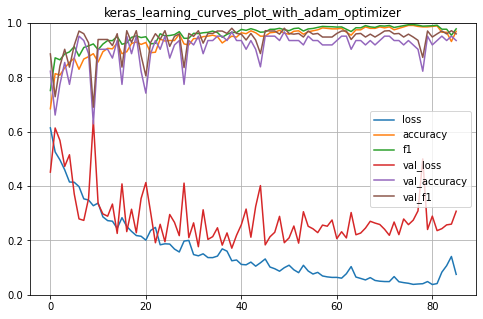

In [ ]:
import matplotlib.pyplot as plt
# plot learning curve
plotLearningCurve(history, OPTIMIZER)

In [ ]:
model = keras.models.load_model('./final_model.h5',custom_objects={"f1":f1})

In [ ]:
# make prediction on test set
y_prediction = model.predict(X_test)
y_prediction_bool = (y_prediction > 0.5).astype(int)

In [ ]:
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    # K.get_session().run(tf.local_variables_initializer())
    return auc

In [ ]:

print("classification report with "+ OPTIMIZER +  "\n")
from sklearn.metrics import classification_report
# y_prediction_bool = y_prediction_bool.reshape((28,1))
print(classification_report(y_test, y_prediction_bool))

classification report with adam

              precision    recall  f1-score   support

           0       0.69      0.86      0.77        36
           1       0.95      0.88      0.92       120

    accuracy                           0.88       156
   macro avg       0.82      0.87      0.84       156
weighted avg       0.89      0.88      0.88       156



In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_prediction_bool)
print('ROC AUC=%.3f' % (auc))

ROC AUC=0.872


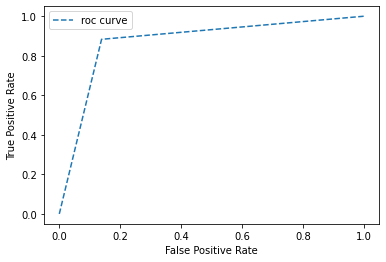

In [ ]:
# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, y_prediction_bool)
# plot the roc curve for the model
from matplotlib import pyplot
pyplot.plot(fpr, tpr, linestyle='--', label='roc curve')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_prediction_bool))

0.8722222222222222


In [ ]:
len(X_test)

156

In [ ]:
len(X_train_final)

558

In [ ]:
len(X_validation_final)

62